In [1]:
# Packages import
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pyDOE as doe
import sklearn.gaussian_process.kernels as skl
import pymc3 as pm
import theano.tensor as tt
import theano
import time
import seaborn as sns
from tqdm import tqdm
import sys
from joblib import Parallel, delayed
import multiprocessing
import psutil
import os
import shutil
import copy
from matplotlib import gridspec
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import pickle

import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy.optimize import brute
import scipy.optimize as so
from scipy.optimize import Bounds
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold

from scipy.sparse.csgraph import shortest_path
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Utilities

In [2]:
#### Variale transformation for unconstrained optimization
def transform(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) + 1)
        return phi
    else:
        return np.log(np.exp(phi) + 1)
    
def inv_transform(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) - 1)
        return phi
    else:
        return np.log(np.exp(phi) - 1)

#### Sigma estimation utilites
def sigma_estimate(obs, indices):
    obs_ordered = obs[indices]
    squares = 0
    for i in range(len(indices) - 1):
        squares = squares + (obs_ordered[i + 1] - obs_ordered[i])**2
        
    return np.sqrt(squares / (2 *(len(indices) - 1)))

def path_algorithm_sigma(input_obs, input_y):
    
    min_index = np.argmin(np.sum(np.abs(input_obs), axis = 1))
    min_value = input_y[min_index]
    min_input = input_obs[min_index,:]
    
    # Flip y
    input_y[min_index] = input_y[0]
    input_y[0] = min_value
    
    # Flip input
    input_obs[min_index,:] = input_obs[0,:]
    input_obs[0,:] = min_input
    
    distance_matrix = sp.spatial.distance_matrix(input_obs, input_obs, p = 1)
    
    visited_array = [0]
    for i in range(len(input_obs) - 1):
        visiting_row = distance_matrix[visited_array[i],:]
        visiting_row[visited_array] = np.ones(len(visited_array)) * np.infty
        new_node = np.argmin(visiting_row)
        visited_array = visited_array + [int(new_node)]
    return visited_array, input_y[visited_array]

    
#### Mean classes defintion for GPs
class model_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of computer model GP
        
        Args:
            param: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x, theta):
        """Zero mean: m(x,theta) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters  
        Returns: 0
        """
        return 0
    
    def constant(self, x, theta):
        """Constant mean: m(x,theta) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def dot_product(self, x, theta):
        """Dot product mean: m(x,theta) = \Beta * x * theta^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        
        return self.hyperparameters["Beta"] * np.dot(x, theta)
    
    def linear(self, x, theta):
        """Linear mean: m(x,theta) = Intercept + \Beta * (x, theta)^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x) + length(theta)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], np.concatenate(x, theta))
        return mean
    
    def LDM(self, x, theta):
        """Liquid drop model mean, see https://arxiv.org/abs/2002.04151 for details
        
        Args:
            x[0] - Proton number Z
            x[1] - Neutron number n
        
        """
        A = x[0] + x[1]
        predictors = np.array([A, -A ** (2/3), -((x[1] - x[0]) ** 2) / A, -x[0]*(x[0] -1) / (A ** (1/3))])
        
        return np.dot(predictors, theta)
    
    def harmonic(self, x, theta):
        """ as defined in the 
           simulation setup in Kejzlar and Maiti (2020): 
           
           m(x,theta) = \Beta * (\theta_1 * cos(x_1) + \theta_2 * cos(x_2))
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        if x.ndim == 1:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[0]), np.sin(x[1])]), theta)
        else:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[:,0]), np.sin(x[:,1])]), theta)
            
        
class delta_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of model discrepancy GP
        
        Args:
            param: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x):
        """Zero mean: m(x) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
        Returns: 0
        """
        return 0
    
    def constant(self, x):
        """Constant mean: m(x) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def linear(self, x):
        """Linear mean: m(x) =Intercept + \Beta * x^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], x)
        return mean
    
def input_locations(d_input, n_input, lims, criterion = "c"): #Works for general case
    """Simulation inputs generator
    
    The function generates inputs for model/observations according to latin hypercube design/uniform
    within given range and dimension of inputs
    
    Args:
        d_input: The dimension of inputs to be generated
        n_input: The number of inputs
        lims: Ndarray with the range of inputs for each variable , each row is limits for each var
        criterion: "uniform" for unifomr "c", "m" for different version of latin hypercube design
        
    Returns:
        inputs: n_input * d_input Ndarray with generated input points.
    """
    if criterion == "uniform":
        inputs = []
        for i in range(d_input):
            inputs = inputs + [np.linspace(lims[i, 0], lims[i, 1], int(n_input ** (1 / d_input)))]
            
        grid_list = np.meshgrid(*inputs)
        
        inputs = np.zeros((n_input, d_input))
        for i in range(d_input):
            inputs[:,i] = grid_list[i].flatten()        
        
    else:
        # Data generation
        inputs = doe.lhs(d_input, samples = n_input, criterion = criterion)

        # Transformation for the interval
        for i in range(d_input):
            inputs[:,i] = inputs[:,i] * (lims[i,1] - lims[i, 0]) + lims[i, 0]

    return inputs

def gp_mean_cov(input_obs, input_m, d_input, theta, kernels_input, means_input):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is marginal likelihood of Y,Z|Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * input_obs.shape[0] + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * input_obs.shape[0])
    
    ##### Means part
    #print(K)
    K = K + np.diag([0.01 ** 2] * len(kernel_input))

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
    
    
    return M, K, kernel_input

def gp_mean_cov_Ynew_predictive(input_obs_new, input_obs, input_m, d_input, theta, kernels_input, means_input, Y_Z):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is predictive likelihood of Zeta_new|Y,Z,Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    input_obs = np.concatenate([input_obs_new, input_obs], axis = 0)
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0]) + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]))
    
    ##### Means part
    #print(K)

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
        
    M_new = M[:input_obs_new.shape[0]]
    M_old = M[input_obs_new.shape[0]:]
        
    S11 = K[:input_obs_new.shape[0], :input_obs_new.shape[0]]
    S12 = K[:input_obs_new.shape[0],input_obs_new.shape[0]:]
    S22 = K[input_obs_new.shape[0]:,input_obs_new.shape[0]:]
    
    M_pred = M_new[:,None] + np.dot(S12, np.linalg.solve(S22, Y_Z[:,None] - M_old[:,None]))
    K_pred = S11 - np.dot(S12, np.linalg.solve(S22, S12.T))
    return M_pred.flatten(), K_pred, kernel_input

def gp_mean_cov_Zeta_trace(trace, input_obs_new, input_obs, input_m, d_input, means, Y_Z, n_sample):
    
    samples = np.zeros((len(input_obs_new), n_sample))
    
    for i in tqdm(range(n_sample), desc = "Sample count"):
        
        theta = trace[-(i+1)]["theta"]
        noise = trace[-(i+1)]["sigma"]
        kernel_f_eta = trace[-(i+1)]["kernel_f_eta"]
        kernel_f_l = trace[-(i+1)]["kernel_f_l"]
        kernel_delta_l = trace[-(i+1)]["kernel_delta_l"]
        kernel_delta_eta = trace[-(i+1)]["kernel_delta_eta"]
        
        # mean delta
        if means["delta"] == "constant":
            delta_beta = trace[-(i+1)]["delta_beta"]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        
        M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs,
                                                        input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        #M, K, kernel_pred = gp_mean_cov_Ynew_predictive(input_obs_new, input_obs,
        #                                                input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        if np.linalg.matrix_rank(K) == len(input_obs_new):
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            new_sample = mvn.sample(1)
            samples[:, i] = new_sample.numpy().flatten()
    
    return samples

def gp_mean_cov_Ynew_trace(trace, input_obs_new, input_obs, input_m, d_input, means, Y_Z, n_sample):
    
    samples = np.zeros((len(input_obs_new), n_sample))
    
    for i in tqdm(range(n_sample), desc = "Sample count"):
        
        theta = trace[-(i+1)]["theta"]
        noise = trace[-(i+1)]["sigma"]
        kernel_f_eta = trace[-(i+1)]["kernel_f_eta"]
        kernel_f_l = trace[-(i+1)]["kernel_f_l"]
        kernel_delta_l = trace[-(i+1)]["kernel_delta_l"]
        kernel_delta_eta = trace[-(i+1)]["kernel_delta_eta"]
        
        # mean delta
        if means["delta"] == "constant":
            delta_beta = trace[-(i+1)]["delta_beta"]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        
        #M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs,
        #                                                input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        M, K, kernel_pred = gp_mean_cov_Ynew_predictive(input_obs_new, input_obs,
                                                        input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        if np.linalg.matrix_rank(K) == len(input_obs_new):
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            new_sample = mvn.sample(1)
            samples[:, i] = new_sample.numpy().flatten()
    
    return samples

def gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs, input_m, d_input, theta, kernels_input, means_input, Y_Z):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is predictive likelihood of Zeta_new|Y,Z,Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    input_obs = np.concatenate([input_obs_new, input_obs], axis = 0)
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([0.01 ** 2] * input_obs_new.shape[0] + [kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]) + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]))
    
    ##### Means part
    #print(K)

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
        
    M_new = M[:input_obs_new.shape[0]]
    M_old = M[input_obs_new.shape[0]:]
        
    S11 = K[:input_obs_new.shape[0], :input_obs_new.shape[0]]
    S12 = K[:input_obs_new.shape[0],input_obs_new.shape[0]:]
    S22 = K[input_obs_new.shape[0]:,input_obs_new.shape[0]:]
    
    M_pred = M_new[:,None] + np.dot(S12, np.linalg.solve(S22, Y_Z[:,None] - M_old[:,None]))
    K_pred = S11 - np.dot(S12, np.linalg.solve(S22, S12.T))
    return M_pred.flatten(), K_pred, kernel_input


class calibration_likelihood:
    
    def __init__(self, input_obs, input_m, d_input, theta_input, theta_truth,
                 Y_Z, means, CV_k = 5, sigma_estimate = None, f_fit = None, input_omega = None, lambda_L2 = 1):
            
        self.input_obs = input_obs
        self.input_m= input_m
        self.theta_input = theta_input #dimension
        self.d_input = d_input
        self.Y_Z = Y_Z
        self.theta_truth = theta_truth
        self.means = means
        self.f_fit = f_fit
        self.CV_k = CV_k
        self.input_omega = input_omega
        self.lambda_L2 = lambda_L2
        self.sigma_estimate = sigma_estimate
        
    def loss_MLE(self,x):
        
        theta_input = self.theta_input
        d_input = self.d_input
        
        if self.sigma_estimate is not None:
            x = np.concatenate([x[:theta_input], np.array([self.sigma_estimate]), x[theta_input:]])
        
        theta = x[:theta_input]
        if self.sigma_estimate is not None:
            noise = np.array([x[theta_input]])
        else:
            noise = transform(np.array([x[theta_input]]))
        kernel_f_l = transform(x[(theta_input + 1):(1 + 2 * theta_input + d_input)])
        kernel_f_eta = transform(x[(1 + 2* theta_input + d_input):(2 + 2 * theta_input + d_input)])
        kernel_delta_l = transform(x[(2 + 2 * theta_input + d_input): (2 + 2 * theta_input + d_input + d_input)])
        kernel_delta_eta = transform(x[(2 + 2 * theta_input + d_input + d_input)])
        
        # mean delta
        if self.means["delta"] == "constant":
            delta_beta = x[(2 + 2 * theta_input + d_input + d_input +  1)]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
        
        M, K, kernel_input = gp_mean_cov(self.input_obs, self.input_m, self.d_input, theta, kernels_input, means_input)
        #print(check_symmetric(K))
        #print(isPD(K))

        tfd = tfp.distributions
        mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
        return - mvn.log_prob(self.Y_Z).numpy()
    
    def loss_CV(self,x_new):
        x = copy.deepcopy(x_new)
        
        theta_input = self.theta_input
        d_input = self.d_input
        
        if self.sigma_estimate is not None:
            x = np.concatenate([x[:theta_input], np.array([self.sigma_estimate]), x[theta_input:]])
        
        theta = x[:theta_input]
        if self.sigma_estimate is not None:
            noise = np.array([x[theta_input]])
        else:
            noise = transform(np.array([x[theta_input]]))
        kernel_f_l = transform(x[(theta_input + 1):(1 + 2 * theta_input + d_input)])
        kernel_f_eta = transform(x[(1 + 2* theta_input + d_input):(2 + 2 * theta_input + d_input)])
        kernel_delta_l = transform(x[(2 + 2 * theta_input + d_input): (2 + 2 * theta_input + d_input + d_input)])
        kernel_delta_eta = transform(x[(2 + 2 * theta_input + d_input + d_input)])
        
        # mean delta
        if self.means["delta"] == "constant":
            delta_beta = x[(2 + 2 * theta_input + d_input + d_input +  1)]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        kf = KFold(self.CV_k, True)
        
        Y = self.Y_Z[:len(self.input_obs)]
        Z = self.Y_Z[len(self.input_obs):]
        
        log_probs = []
        for train, test in kf.split(self.input_obs):
            Y_cv = Y[train]
            Y_Z_cv = np.concatenate([Y_cv, Z])
            M, K, kernel_input = gp_mean_cov_Ynew_predictive(self.input_obs[test], self.input_obs[train], self.input_m, self.d_input,
                                                                         theta, kernels_input, means_input, Y_Z_cv)
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            log_probs = log_probs + [float(mvn.log_prob(Y[test]).numpy())]
        #print(log_probs)
        return - np.sum(np.array(log_probs))
    
    def M_K(self,x):
        theta_input = self.theta_input
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
        # Kernels input not
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        delta_hyperparameters = {"Beta": float(1)}
        #delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        means_input = {"f": f_mean_init.zero, "delta": delta_mean_init.zero}
        
        
        M, K, kernel_input = gp_mean_cov(self.input_obs, self.input_m, self.d_input, theta, kernels_input, means_input)
        
        return M,K, kernel_input
    
    def predictive_likelihood(self, x, new_input):
        # predictive likelihood of the physical proces
        theta_input = self.theta_input
        d_input = self.d_input
        
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        
        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_f)

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_delta)
        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        
        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_productS
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
            
        M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(new_input, self.input_obs,
                                                         self.input_m, self.d_input, theta, kernels_input, means_input, self.Y_Z)
        
        return M, K
    
    def predictive_likelihood_obs(self, x, new_input):
        # predictive likelihood of the physical proces
        theta_input = self.theta_input
        d_input = self.d_input
        
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        
        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_f)

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_delta)
        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        
        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
            
        M, K, kernel_pred = gp_mean_cov_Ynew_predictive(new_input, self.input_obs,
                                                         self.input_m, self.d_input, theta, kernels_input, means_input, self.Y_Z)
        
        return M, K
    
    def MSE(self, x):
        
        x_inputs = np.concatenate([x, self.noise, self.kernel_f_l, self.kernel_f_eta, self.kernel_delta_l, np.array([self.kernel_delta_eta])])
        
        M_p, K_p = self.predictive_likelihood(x_inputs, self.input_obs)
        M_p_f, K_p_f = self.predictive_likelihood_cm(x_inputs, self.input_obs)
        
        MSE = np.mean((M_p - M_p_f)**2)
        return MSE
        
def traveling_wave(x, t, A, k, phi, omega):
    return A * np.sin(k * x - omega * t + phi)

# Simulation - Wave propagation

In [18]:
# Simulation setup
A = 1.2# theta 1
k = 5
omega = 1.8# theta 2
phi = 1
# Noise level
noise = 1 / 5
# Offset as a constant
beta = 1

theta = np.array([A, omega])

# Observation generation
tf.random.set_seed(123)
np.random.seed(123)

d_input = 2
theta_input = 2
n_obs = 250
# first dimesion is location second is time
lims = np.array([[0, 1], [0, 1]])
input_obs = input_locations(d_input, n_obs, lims=lims, criterion = "c")
X_obs = input_obs[:,0]
T_obs = input_obs[:,1]
Y = traveling_wave(X_obs, T_obs, A, k, phi, omega) + beta +np.random.normal(loc = 0, scale = noise, size = n_obs)


# Model runs generation
n_m = 250
lims = np.array([[0, 1], [0,1], [0, 2], [0, 2]])
input_m = input_locations(theta_input + d_input, n_m, lims=lims, criterion = "c")
X_m = input_m[:,0]
T_m = input_m[:,1]
A_m = input_m[:,2]
omega_m = input_m[:,3]
Z = traveling_wave(X_m, T_m, A_m, k, phi, omega_m)
Y_Z = np.concatenate([Y,Z])

# Testing data generation
# Observatio generation testing dataset
lims = np.array([[0, 1], [0,1]])
n_test = 225
input_test = input_locations(d_input, n_test, lims=lims, criterion = "uniform")
X_test = input_test[:,0]
T_test = input_test[:,1]
Y_test = traveling_wave(X_test, T_test, A, k, phi, omega) + beta

# L2 loss minimizer / Validation set
n_L2 = 225
# first dimesion is location second is time
lims = np.array([[0, 5], [0, 5]])
input_omega = input_locations(d_input, n_L2, lims=lims, criterion = "uniform")

X_m = input_omega[:,0]
T_m = input_omega[:,1]
Z_valid = traveling_wave(X_m, T_m, A, k, phi, omega)

In [8]:
# Consistent sigma estimation
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
sigma_estimate(y_ordered, input_obs_sorted_index)

0.3282342771223081

## MCMC Fit

In [39]:
#### Formating data into a data_input dictionary format 
# This is independent from any GP specification or the type of variance reduction used

# index generating
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc. index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y[:,None]), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z[:,None]), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

# Input values theta
theta_variational = theta
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_input), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs

### Save the data_input dictionary as .pickle file
#with open(str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
#    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)
###

### Load the data_input dictionary from .pickle file
#with open(str(n_obs) + '_' + str(n_m) + "_" + str(lims[0][1]) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
###

tf.random.set_seed(123)
np.random.seed(123)

# Preprocessing input
def observations_scale(x):
    return x[:, -1]

# Preprocessing all the shared data
obs_indicator = data_input["Response"][:,1][:,None]
X_obs_indicator = np.concatenate([data_input["X"][:,1:], obs_indicator], axis = 1)
X_shared = theano.shared(data_input["X"][:,1:])
theta_model_shared = theano.shared(input_m[:,d_input:])
sampler_type = "MH" # "MH" or "NUTS"
n_tune = 5000 # Number of tuning samples
n_sample = 10000 # Number of effective samples

# Means specification
##### Means definition
model_hyperparameters = {"Beta": float(1)}
delta_hyperparameters = {"Beta": float(1)}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)

means = {"f": f_mean_init.zero, "delta": delta_mean_init.zero }
# Priors definition
priors_dictionary ={"theta": [0, 2, 2],
                   "sigma": [3, 1, 1],
                   "kernel_f_l": [1, 3, 4],
                   "kernel_f_eta": [3, 1, 1],
                   "kernel_delta_l": [1, 3, 2],
                   "kernel_delta_eta": [3, 1, 1]}

#n_mu = float(sys.argv[2])
#n_s = float(sys.argv[3])
#g_a = float(sys.argv[4])
#g_b = float(sys.argv[5])
#ig_a = float(sys.argv[6])
#ig_b = float(sys.argv[7])

#priors_dictionary ={"theta": [n_mu, n_s, 2],
#                   "sigma": [ig_a, ig_b, 1],
#                   "kernel_f_l": [g_a, g_b, 4],
#                   "kernel_f_eta": [ig_a, ig_b, 1],
#                   "kernel_delta_l": [g_a, g_b, 2],
#                   "kernel_delta_eta": [ig_a, ig_b, 1]}

with pm.Model() as full_bayes:
    
    ## Priors definition
    # Theta prior
    theta_random = pm.Normal("theta", mu = priors_dictionary["theta"][0],
                        sd= priors_dictionary["theta"][1],
                        shape =  priors_dictionary["theta"][2])
    
    ## Noise Prior
    noise = pm.InverseGamma("sigma", alpha = float(priors_dictionary["sigma"][0]),
                     beta = priors_dictionary["sigma"][1])
    
    ### Kernel f hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_f_l"][2]> 1:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                              beta = float(priors_dictionary["kernel_f_l"][1]),
                              shape = priors_dictionary["kernel_f_l"][2])
    else:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                          beta = float(priors_dictionary["kernel_f_l"][1]))
    ## eta
    kernel_f_eta = pm.InverseGamma("kernel_f_eta", alpha = float(priors_dictionary["kernel_f_eta"][0]),
                            beta = float(priors_dictionary["kernel_f_eta"][1]))
    
    ### Kernel delta hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_delta_l"][2]> 1:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = priors_dictionary["kernel_delta_l"][0],
                                  beta = priors_dictionary["kernel_delta_l"][1],
                                  shape = priors_dictionary["kernel_delta_l"][2])
    else:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = np.float(priors_dictionary["kernel_delta_l"][0]),
                              beta = np.float(priors_dictionary["kernel_delta_l"][1]))
    ## eta
    kernel_delta_eta = pm.InverseGamma("kernel_delta_eta", alpha = float(priors_dictionary["kernel_delta_eta"][0]),
                                beta = float(priors_dictionary["kernel_delta_eta"][1]))
    
    ## Means priors
    if "mean_f" in priors_dictionary:
        if priors_dictionary["mean_f"][2]> 1:
            mean_f = pm.Normal("mean_f", mu = priors_dictionary["mean_f"][0],
                               sd = priors_dictionary["mean_f"][1],
                               shape = priors_dictionary["mean_f"][2])
        else:
            mean_f = pm.Normal("mean_f", mu = float(priors_dictionary["mean_f"][0]),
                               sd = float(priors_dictionary["mean_f"][1]))
            
        
    if "mean_delta" in priors_dictionary:
        if priors_dictionary["mean_delta"][2] > 1:
            mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                   sd = priors_dictionary["mean_delta"][1],
                                   shape = priors_dictionary["mean_delta"][2])
        else:
            mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                   sd = float(priors_dictionary["mean_delta"][1]))
            
            
    # Noise covariance
    cov_noise_base = pm.gp.cov.WhiteNoise(noise)
    cov_noise = pm.gp.cov.ScaledCov(1, cov_func = cov_noise_base, scaling_func = observations_scale)
    
    # Systematic discrepancy covariance
    cov_delta_base = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(d_input + 1, ls = kernel_delta_l,
                                                                active_dims = [i for i in range(d_input)])
    
    cov_delta = pm.gp.cov.ScaledCov(d_input + 1, cov_func = cov_delta_base, scaling_func = observations_scale)
    
    #Preprocessing theta
    thetas_variable = tt.concatenate([tt.tile(theta_random, (int(np.sum(obs_indicator)), 1)), theta_model_shared], axis = 0)
    X_thetas_variable = tt.concatenate([X_shared, thetas_variable], axis = 1)
    
    cov_f = kernel_f_eta ** 2 * pm.gp.cov.ExpQuad(d_input + theta_input, ls = kernel_f_l)
    
    # Complete covariance specification
    K = cov_f(X_thetas_variable) + cov_delta(X_obs_indicator) + cov_noise(obs_indicator)
    # Mean definition
    # Mean f
    if "mean_f" in priors_dictionary:
        if means["f"] == "constant":
            mu_f = mean_f * np.ones(len(data_input["Response"]))
        elif means["f"] == "dot_product":
            mu_f = mean_f * tt.diag(tt.dot(data_input["X"][:,1:], thetas_variable.T))
        elif means["f"] == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(mean_f, ones_X_thetas_variable.T)          
    else:
        if means["f"].__name__ == "zero":
            mu_f = 0 * obs_indicator.flatten()
        elif means["f"].__name__ == "constant":
            mu_f = f_mean_init.hyperparameters["Beta"] * np.ones(len(data_input["Response"]))
        elif means["f"].__name__ == "dot_product":
            mu_f = f_mean_init.hyperparameters["Beta"] * tt.diag(tt.dot(np.concatenate([np.cos(data_input["X"][:,1])[:,None], np.sin(data_input["X"][:,2])[:,None]], axis = 1), thetas_variable.T))
        elif means["f"].__name__ == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(np.array([f_mean_init.hyperparameters["Intercept"],f_mean_init.hyperparameters["Beta"]]).flatten(),
                          ones_X_thetas_variable.T)  
            
    # Mean delta
    if "mean_delta" in priors_dictionary:
        if means["delta"] == "constant":
            mu_delta = mean_delta * obs_indicator.flatten()
        elif means["delta"] == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(mean_delta, ones_X.T)  
    else:
        if means["delta"].__name__ == "zero":
            mu_delta = 0 * obs_indicator.flatten()
        elif means["delta"].__name__ == "constant":
            mu_delta = delta_mean_init.hyperparameters["Beta"] * obs_indicator.flatten()
        elif means["delta"].__name__ == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(np.array([delta_mean_init.hyperparameters["Intercept"],delta_mean_init.hyperparameters["Beta"]]).flatten(),
                              ones_X.T)
            
    mu = mu_f + mu_delta    
    obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"][:,-1])
    if sampler_type == "MH":
        step = pm.Metropolis()
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, step = step, discard_tuned_samples = False)
    elif sampler_type == "NUTS":
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, discard_tuned_samples = False)
    # Saves trace    
    #pm.backends.ndarray.save_trace(trace, "trace_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + "_" + str(n_m) + "_nsample_" 
    #                               + str(n_sample) + "_sampler_" + sampler_type, overwrite=True)

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


## Sensitivity analyisis preload

In [144]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Sim1/trace_500_500_nsample_10000_sampler_MH")

In [150]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Sim1/trace_2_250_250_nsample_20000_sampler_MH")

In [ ]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Sim1/trace_125_125_nsample_10000_sampler_MH")

In [553]:
# loading sensitivity analysis

g_b = 3.0
ig_a = 3.0

names = ["RMSE", "n", "n_mu", "n_s", "g_a", "g_b", "ig_a", "ig_b", "theta_1", "theta_2", "sigma"]
results_data = pd.DataFrame(columns= names)
false_count = 0

for n_mu in [0.0, 1.0, 1.5]:
    for n_s in [0.25, 0.5, 1.0, 2.0]:
        for g_a in [1.0, 5.0, 10.0, 15.0, 20.0]:
            for ig_b in [0.5, 1.0, 2.0, 4.0, 8.0]: 
                entry = np.zeros((3,11))
                for n_obs in [125, 250, 500]:
                    try:
                        n_m = n_obs
                        with open("Sensitivity_analysis/test_samples_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
                                pred_sample = pkl.load(handle)
                        results_data.append(pd.DataFrame(entry, columns = names))
                        rmse = np.sqrt(np.mean((Y_test - np.mean(pred_sample, axis = 1))** 2))

                        with full_bayes:
                            trace = pm.backends.ndarray.load_trace("Sensitivity_analysis/trace_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + '_' + str(n_m) + "_nsample_10000_sampler_MH")

                        theta_1 = np.mean(trace["theta"][5000:], axis = 0)[0]
                        theta_2 = np.mean(trace["theta"][5000:], axis = 0)[1]
                        sigma_pos = np.mean(trace["sigma"][5000:])
                        if n_obs == 125:
                            entry[0,0] = rmse
                            entry[0,1] = int(n_m)
                            entry[0,2] = n_mu
                            entry[0,3] = n_s
                            entry[0,4] = g_a
                            entry[0,5] = g_b
                            entry[0,6] = ig_a
                            entry[0,7] = ig_b
                            entry[0,8] = theta_1
                            entry[0,9] = theta_2
                            entry[0,10] = sigma_pos
                        elif n_obs == 250:
                            entry[1,0] = rmse
                            entry[1,1] = int(n_m)
                            entry[1,2] = n_mu
                            entry[1,3] = n_s
                            entry[1,4] = g_a
                            entry[1,5] = g_b
                            entry[1,6] = ig_a
                            entry[1,7] = ig_b
                            entry[1,8] = theta_1
                            entry[1,9] = theta_2
                            entry[1,10] = sigma_pos
                        elif n_obs == 500:
                            entry[2,0] = rmse
                            entry[2,1] = int(n_m)
                            entry[2,2] = n_mu
                            entry[2,3] = n_s
                            entry[2,4] = g_a
                            entry[2,5] = g_b
                            entry[2,6] = ig_a
                            entry[2,7] = ig_b
                            entry[2,8] = theta_1
                            entry[2,9] = theta_2
                            entry[2,10] = sigma_pos

                        if (n_obs == 500):
                            if np.all(entry[:,0] <= 0.15) and np.all(np.sort(entry[:,0])[::-1] == entry[:,0]):
                                results_data =  results_data.append(pd.DataFrame(entry, columns = names))
                            else:
                                false_count = false_count + 1
                    except:
                        print("not found")

not found
not found
not found


In [554]:
# Ranges RMSE
print("500 min: " + str(np.min(results_data[results_data["n"] == 500.0]["RMSE"].values)))
print("500 max: " + str(np.max(results_data[results_data["n"] == 500.0]["RMSE"].values)))

print("250 min: " + str(np.min(results_data[results_data["n"] == 250.0]["RMSE"].values)))
print("250 max: " + str(np.max(results_data[results_data["n"] == 250.0]["RMSE"].values)))

print("125 min: " + str(np.min(results_data[results_data["n"] == 125.0]["RMSE"].values)))
print("125 max: " + str(np.max(results_data[results_data["n"] == 125.0]["RMSE"].values)))

500 min: 0.016074174562554115
500 max: 0.04248873070403019
250 min: 0.019931623814221488
250 max: 0.06737188309143491
125 min: 0.041689404246102055
125 max: 0.07200748638936565


In [456]:
# Ranges theta
filter_results = results_data[np.logical_not(np.logical_and(results_data["n_mu"] == 0, results_data["n_s"] == 0.25))]
print("500 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["theta_1"].values)))
print("500 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["theta_1"].values)))

print("250 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["theta_1"].values)))
print("250 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["theta_1"].values)))

print("125 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["theta_1"].values)))
print("125 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["theta_1"].values)))

print("500 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["theta_2"].values)))
print("500 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["theta_2"].values)))

print("250 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["theta_2"].values)))
print("250 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["theta_2"].values)))

print("125 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["theta_2"].values)))
print("125 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["theta_2"].values)))

print("500 sigma min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["sigma"].values)))
print("500 sigma max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["sigma"].values)))

print("250 sigma min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["sigma"].values)))
print("250 sigma max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["sigma"].values)))

print("125 sigma min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["sigma"].values)))
print("125 sigma max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["sigma"].values)))




500 theta1 min: 1.0544458627700806
500 theta1 max: 1.2285271883010864
250 theta1 min: 1.1526033878326416
250 theta1 max: 1.2002239227294922
125 theta1 min: 1.0995646715164185
125 theta1 max: 1.3092821836471558
500 theta2 min: 1.4869489669799805
500 theta2 max: 1.7787419557571411
250 theta2 min: 1.700606107711792
250 theta2 max: 1.7865045070648193
125 theta2 min: 1.4897655248641968
125 theta2 max: 1.792312741279602
500 sigma min: 0.19600485265254974
500 sigma max: 0.2044501155614853
250 sigma min: 0.2031661570072174
250 sigma max: 0.22157703340053558
125 sigma min: 0.2047625184059143
125 sigma max: 0.24151882529258728


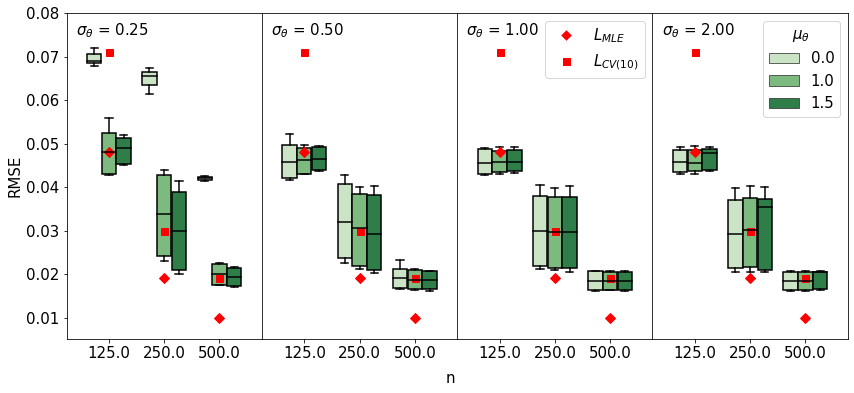

In [603]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,6))
#gs = gridspec.GridSpec(4, 1, width_ratios=[1, 1])
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0, hspace=0)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

pall = "Greens"
lw = 3
box_width = 0.8
lcol = "red"
markersize= 7


sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 0.25], hue = "n_mu", palette=pall, ax = ax0, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 0.5], hue = "n_mu", palette=pall, ax = ax1, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 1.0], hue = "n_mu", palette=pall, ax = ax2, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 2.0], hue = "n_mu", palette=pall, ax = ax3, width = box_width)

# Axes edition
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")



ax0.legend().remove()
ax1.legend().remove()
ax2.legend().remove()
ax3.legend(title=r"$\mu_{\theta}$")

for i in range(4):
    
    if i == 0:
        axes = ax0
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 0.25")
    elif i == 1:
        axes = ax1
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 0.50")
    elif i == 2:
        axes = ax2
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 1.00")
        
        colors = ['red']
        lines = [Line2D([0], [0], color="w", marker = "D", markerfacecolor=lcol, markersize=markersize +2),
                 Line2D([0], [0], color="w", marker = "s", markerfacecolor=lcol, markersize=markersize +2)]
        labels = [r'$L_{MLE}$', r"$L_{CV(10)}$"]
        axes.legend(lines, labels)
    elif i == 3:
        axes = ax3
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 2.00")
        
    axes.set_ylim([0.005,0.08])
    axes.set_xlabel("")
        
    plt.setp(axes.artists, edgecolor = 'k')
    plt.setp(axes.lines, color = 'k')

        

    axes.plot(0,0.048,marker="D",lw= lw, markersize=markersize, color = lcol, label = r"$L_{MLE}$")
    axes.plot(0,0.071,marker="s",lw= lw, markersize=markersize, color = lcol, label = r"$L_{CV(10)}$")
    #if i == 2:
    #    axes.legend([axes],[r"$L_{MLE}$", r"$L_{CV(10)}$"])
    axes.plot(1,0.019, marker="D",lw= lw,markersize=markersize, color = lcol)
    axes.plot(1,0.03,marker="s",lw= lw,markersize=markersize, color = lcol)
    axes.plot(2,0.01, marker="D",lw= lw,markersize=markersize, color = lcol)
    axes.plot(2,0.019,marker="s",lw= lw,markersize=markersize, color = lcol)


plt.text(-4.5, -0.005, "n")
plt.savefig("SensitivityRMSE" + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

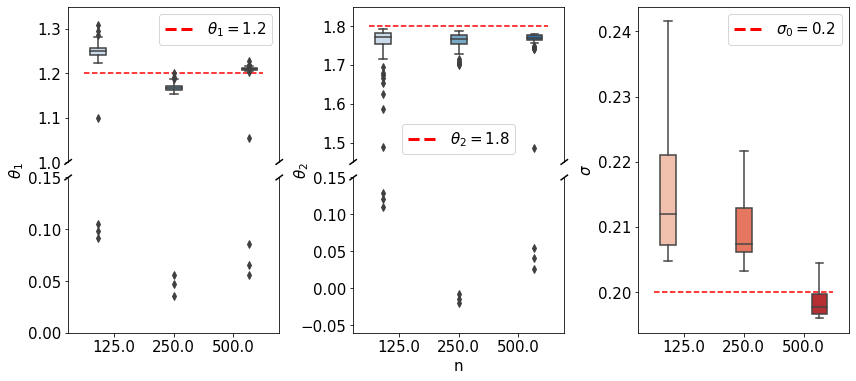

In [588]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,6))
#gs = gridspec.GridSpec(4, 1, width_ratios=[1, 1])
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.35, hspace=0.1)
ls = "--"

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[3])

#plt.rcParams.update({'font.size': 15})
#f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,6))
sns.boxplot(x = "n" , y = "theta_1", data = results_data, hue = "n", ax = ax, palette="Blues",  width = box_width)
sns.boxplot(x = "n" , y = "theta_1", data = results_data, hue = "n", ax = ax2, palette="Blues",  width = box_width)

ax.set_ylim(1.0, 1.35)  # outliers only
ax2.set_ylim(0, .15)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.xaxis.set_visible(False)
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
ax.hlines(1.2, -0.5,2.5, linestyles = ls, color = "red")
ax2.set_xlabel("")
ax2.legend().remove()
ax2.set_ylabel(r"$\theta_1$")
ax2.yaxis.set_label_coords(-0.2, 1.05)

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\theta_1 = 1.2$']
ax.legend(lines, labels)

ax = plt.subplot(gs[1])
ax2 = plt.subplot(gs[4])

#plt.rcParams.update({'font.size': 15})
#f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,6))
sns.boxplot(x = "n" , y = "theta_2", data = results_data, hue = "n", ax = ax, palette="Blues", width = box_width)
sns.boxplot(x = "n" , y = "theta_2", data = results_data, hue = "n", ax = ax2, palette="Blues", width = box_width)

ax.set_ylim(1.45, 1.85)  # outliers only
ax2.set_ylim(-0.06, .15)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.xaxis.set_visible(False)
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.legend().remove()
ax.hlines(1.8, -0.5,2.5, linestyles = ls, color = "red")
ax.set_xlabel("")
ax.set_ylabel("")
ax2.legend().remove()
ax2.set_ylabel(r"$\theta_2$")
ax2.yaxis.set_label_coords(-0.2, 1.05)

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\theta_2 = 1.8$']
ax.legend(lines, labels)

ax = plt.subplot(gs[:,2])
sns.boxplot(x = "n" , y = "sigma", data = results_data, hue = "n", ax = ax, palette="Reds", width = box_width)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel(r"$\sigma$")

ax.hlines(0.2, -0.5,2.5, linestyles = ls, color = "red", label = r"$\sigma_0 = 0.2$")

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\sigma_0 = 0.2$']
ax.legend(lines, labels)
plt.savefig("SensitivityParams" + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## L_MLE

In [19]:
# Finding the hyperparameters - sigma is estimated first
# The optimization is conducted using the L-BFGS-B algorithm
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, sigma_estimate = s_hat)
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
x[2:] = inv_transform(x[2:])
# This sets the compact space for parameter search
bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8
print(x)
if n_obs == 125:
    res_hyp = minimize(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"maxls":100, "maxiter": 2000, "ftol": 1e-12})
else:
    res_hyp = minimize(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B')
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 1.39293837  0.57227867 -0.55489897  0.69916702  1.16820538  0.28578265
  1.80995721  1.07637038  0.48030582  0.17456696]
      fun: -508.15050763081786
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01375611, -0.0078785 ,  0.03205969, -0.01532499, -0.02467004,
       -0.00881073, -0.00352429, -0.22810127, -0.22278073,  0.01206217])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 594
      nit: 44
   status: 0
  success: True
        x: array([ 1.16027262,  1.80461945, -0.75823847,  0.40125759,  2.68677547,
        1.53540333,  2.04344878,  4.        ,  4.        , -0.13515578])
[ 1.16027262  1.80461945 -1.21657375 -0.75823847  0.40125759  2.68677547
  1.53540333  2.04344878  4.          4.         -0.13515578]


In [16]:
x_mle = copy.deepcopy(x)
x_mle[2:] = transform(x_mle[2:])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 2
M_p, K_p = lkl_class.predictive_likelihood(x_mle, input_test)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))

$\sqrt{MSE}=$ 0.0484


In [906]:
with open("MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump({"x": x, "M": M_p, "K":K_p}, handle, protocol=pkl.HIGHEST_PROTOCOL)

## L_CV

In [144]:
# Finding the hyperparameters - sigma is estimated first
# The optimization is conducted using the L-BFGS-B algorithm
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, CV_k=10, sigma_estimate = s_hat)
x = np.random.uniform(high= 3, size = 2 + 2*theta_input + d_input + d_input)
x[2:] = inv_transform(x[2:])
# This sets the compact space for parameter search
bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8

if n_obs == 125:
    res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"eps":1.5e-1,"maxls":100, "maxiter": 2000, "ftol": 1e-24})
else:
    res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"eps":1.75e-2,"maxls":100, "maxiter": 2000, "ftol": 1e-24})
    
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 2.08940756  0.858418   -0.02534624  1.4416246   2.03566398  0.93939371
  2.888106    1.91734183  1.17325959  0.80760276]
      fun: 14.969081575178357
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([12.20939081,  0.35118914,  1.02636417, -3.93975691, -3.97263678,
       -7.26358083,  1.50342879, -4.20526582, -3.93552195, -1.90134386])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 7
   status: 0
  success: True
        x: array([ 1.21736649,  1.78781142, -0.54330414,  3.34377595,  3.91557337,
        0.87112982,  3.96964311,  1.73796154,  4.        ,  3.96251242])
[ 1.21736649  1.78781142 -0.94542548 -0.54330414  3.34377595  3.91557337
  0.87112982  3.96964311  1.73796154  4.          3.96251242]


In [145]:
x_cv = copy.deepcopy(x)
x_cv[2:] = transform(x_cv[2:])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 2
M_p, K_p = lkl_class.predictive_likelihood(x_cv, input_test)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))

$\sqrt{MSE}=$ 0.0714


In [717]:
with open("CV_" + str(3) + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump({"x": x, "M": M_p, "K":K_p}, handle, protocol=pkl.HIGHEST_PROTOCOL)

# Results calc

n: 125
$\sqrt{MSE}=$ 0.04905
theta: [1.19743034 1.78127289]
$\sqrt{MSE}=$ 0.04845
theta: [1.21736373 1.78780818]
$\sqrt{MSE}=$ 0.07144
n: 250
$\sqrt{MSE}=$ 0.0365
theta: [1.16027262 1.80461945]
$\sqrt{MSE}=$ 0.01934
theta: [1.25099082 1.79925144]
$\sqrt{MSE}=$ 0.03021
n: 500
$\sqrt{MSE}=$ 0.02081
theta: [1.20679129 1.79226253]
$\sqrt{MSE}=$ 0.00985
theta: [1.20597664 1.81756787]
$\sqrt{MSE}=$ 0.01904


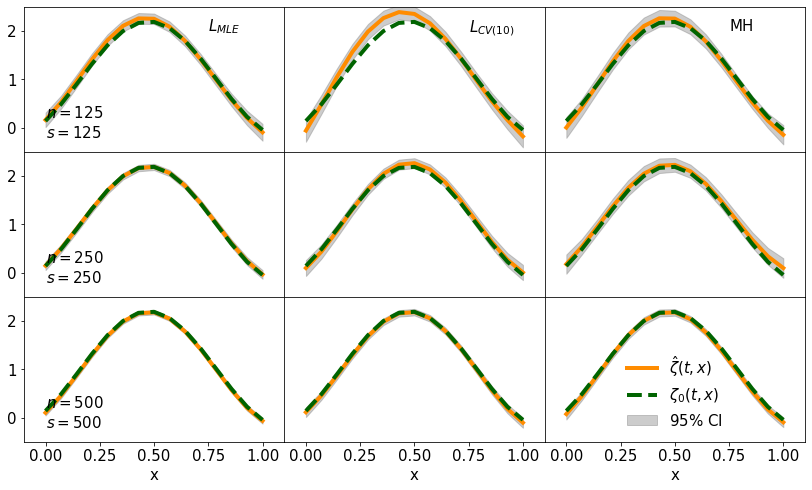

In [5]:
# Below is a display of precalculated results according to the Simulation specifications in
# A Fast and Calibrated Computer Model Emulator: An Empirical Bayes Approach by Kejzlar et. al. 2020
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1,1])
gs.update(wspace=0, hspace=0)
lw = 4
#T_test_val = 0
T_test_val = T_test[224]
i = 0
for n_obs in [125, 250, 500]:
    n_m = n_obs
    print("n: " + str(n_obs) )
    with open("Sim1/test_samples_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        pred_sample = pkl.load(handle)
        
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - np.mean(pred_sample, axis = 1)) ** 2)),5)))
        
    with open("Sim1/MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        mle = pkl.load(handle)
        
    print("theta: " + str(mle["x"][:2]))
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - mle["M"].flatten()) ** 2)),5)))
    
    if n_obs == 125:
        name =  "BF_10eps_1.5e-1"
    else:
        name = "BF_10eps_1.75e-2"
        
    with open("Sim1/CV_" + name + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        cv = pkl.load(handle)
        
    print("theta: " + str(cv["x"][:2]))
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - cv["M"].flatten()) ** 2)),5)))
    
    ax0 = plt.subplot(gs[0 + 3*i])
    ax1 = plt.subplot(gs[1 + 3*i])
    ax2 = plt.subplot(gs[2 + 3*i])
    
    mle_std = np.sqrt(np.diag(mle["K"]))
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
    ax0.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
    ax0.fill_between(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val],
                     mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    
    cv_std = np.sqrt(np.diag(cv["K"]))
    ax1.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
    ax1.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
    ax1.fill_between(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
                     cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    mcmc_std = np.std(pred_sample, axis = 1)
    mcmc_m = np.mean(pred_sample, axis = 1)
    ax2.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(t,x)$ ", color = "darkorange")
    ax2.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta_0(t,x)$", ls = "--", lw=lw, color = "darkgreen")
    ax2.fill_between(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
                     mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$ CI")
    
    # Axis settings
    ax1.set_yticks([])
    ax2.set_yticks([])
    
    ax0.set_ylim([-0.5,2.5])
    ax1.set_ylim([-0.5,2.5])
    ax2.set_ylim([-0.5,2.5])
    
    ax0.set_xlim([-0.1,1.1])
    ax1.set_xlim([-0.1,1.1])
    ax2.set_xlim([-0.1,1.1])
    
    # Text
    ax0.text(0, 0.2, r"$n=$" + str(n_obs))
    ax0.text(0, -0.2, r"$s=$" + str(n_m))
    
    if n_obs == 125:
        ax0.text(0.75, 2, r"$L_{MLE}$")
        ax1.text(0.75, 2, r"$L_{CV(10)}$")
        ax2.text(0.75, 2, r"MH")
        
    if n_obs == 500:
        ax0.set_xlabel("x")
        ax1.set_xlabel("x")
        ax2.set_xlabel("x")
        
        ax2.legend(frameon=False)
    
    
    i = i + 1
    
plt.savefig("Sim1" + 't224' + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

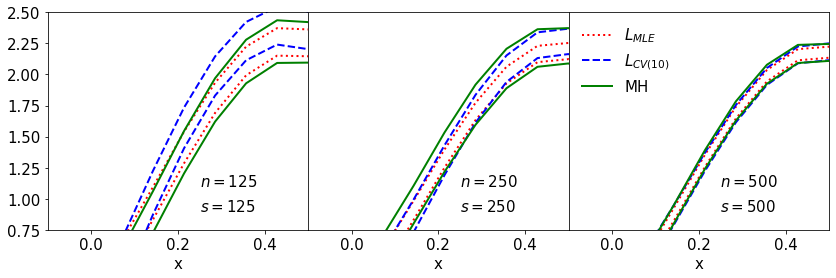

In [37]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])
gs.update(wspace=0, hspace=0)
lw = 2
#T_test_val = 0
T_test_val = T_test[224]
i = 0
for n_obs in [125, 250, 500]:
    n_m = n_obs
    #print("n: " + str(n_obs) )
    with open("Sim1/test_samples_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        pred_sample = pkl.load(handle)
        
        
    with open("Sim1/MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        mle = pkl.load(handle)
        
    
    if n_obs == 125:
        name =  "BF_10eps_1.5e-1"
    else:
        name = "BF_10eps_1.75e-2"
        
    with open("Sim1/CV_" + name + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        cv = pkl.load(handle)
        
    
    ax0 = plt.subplot(gs[i])
    
    mle_std = np.sqrt(np.diag(mle["K"]))
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val],ls = ":",
             lw= lw, color = "red")
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val], label = r"$L_{MLE}$", ls = ":",
             lw=lw, color = "red")
    #ax0.fill_between(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val],
    #                 mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    
    cv_std = np.sqrt(np.diag(cv["K"]))
    ax0.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], ls = "--",
             lw= lw, color = "blue")
    ax0.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
             label = r"$L_{CV(10)}$", ls = "--", lw=lw, color = "blue")
    #ax0.fill_between(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
    #                 cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    mcmc_std = np.std(pred_sample, axis = 1)
    mcmc_m = np.mean(pred_sample, axis = 1)
    ax0.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val],
             lw= lw, color = "green")
    ax0.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
             label = r"MH", lw=lw, color = "green")
    #ax0.fill_between(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
    #                 mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$ CI")
    
    # Axis settings
    if n_obs != 125:
        ax0.set_yticks([])
    
    ax0.set_ylim([0.75,2.5])
    #ax1.set_ylim([-0.5,2.5])
    #ax2.set_ylim([-0.5,2.5])
    
    ax0.set_xlim([-0.1,0.5])
    #ax1.set_xlim([-0.1,1.1])
    #ax2.set_xlim([-0.1,1.1])
    
    # Text
    ax0.text(0.25, 1.1, r"$n=$" + str(n_obs))
    ax0.text(0.25, 0.9, r"$s=$" + str(n_m))
    
    if n_obs == 125:
        #ax0.text(0.75, 2, r"$L_{MLE}$")
        ax1.text(0.75, 2, r"$L_{CV(10)}$")
        ax2.text(0.75, 2, r"MH")
        
    ax0.set_xlabel("x")
    
    if n_obs ==500:
        ax0.legend(frameon=False)
    
    
    i = i + 1
    
plt.savefig("Sim1CB" + 't224' + '.pdf', dpi=300, bbox_inches='tight')
plt.show()